### ETAS 1D
- Create a 1D timeseries of expected seismicity rates based on (not-)ETAS


In [1]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz
tzutc = pytz.timezone('UTC')

#import operator
import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
#from sklearn.neighbors import NearestNeighbors
import sklearn
import sklearn.neighbors
#
import geopy.distance
#from geopy.distance import vincenty
#from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
import global_etas_auto as ggep
from eq_params import *
#
from nepal_figs import *
import optimizers
#
import random
import geopy

#
# on a fresh linux install... (can we script this?)
# stuff we have to do besides just clone this:
# pip install geopy
# conda install basemap
# pip install geographiclib
# conda install -c ioos rtree


failed while loading urllib and/or urllib. maybe python 3.x?


/home/myoder/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:938: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Set basic parameters (lat, lon, time bits, etc.)


In [5]:
# event was some time on the 24th or maybe late the 23rd. this, plus defaults, should find the event:
#
Lr_factor = 10.
#
# newest event:
t0 = dtm.datetime(2018, 4, 5, 19, 29, 16, tzinfo=pytz.timezone('UTC'))
to_dt = dtm.datetime.now(pytz.timezone('UTC'))
#to_dt = t0 + dtm.timedelta(days=15)
#
t_ms = t0
#Location
lon0 = -119.726
lat0 = 33.837  
#
m0 = 5.3
d_lat = 4.
d_lon = 4.
#
lats = [lat0-d_lat, lat0+d_lat]
lons = [lon0-d_lon, lon0+d_lon]

In [27]:
# build an ETAS_1d timeseries class. we'll worry about mpp later.
#
class ETAS_1D(list):
    # inherit from list(); populate as [[t,dt], ...] or [[t,rate], ...]
    #
    def __init__(self, catalog=None, lats=None, lons=None, mc=2.5, mc_etas=None, d_lon=.1, d_lat=.1, bin_lon0=0.,
                 bin_lat0=0., t_0=dtm.datetime(1990,1,1, tzinfo=tz_utc), t_now=dtm.datetime.now(tzutc),
                 cat_len=10.*365., etas_fit_factor=1.0,
                 calc_etas=True, n_contours=15, cmap_contours='jet', etas_cat_range=None, etas_xyz_range=None,
                 p_cat=1.1, q_cat=1.5, ab_ratio_expon=.25, p_etas=None, D_fract=1.5, **kwargs):
        '''
        #
        #  basically: if we are given a catalog, use it. try to extract mc, etc. data from catalog if it's not
        # externally provided. otherwise, get a catalog from ANSS or OH based oon the parameters provided.
        # note: we want to do this properly in an x-y projection, not lat-lon. our earthquakes will come back to us with lat/lon coordinates
        # so we'll need to translate. we'll also want lat/lon as well as x/y positions for the lattice sites, so we can get even spacing and accurate distances
        #
        # etas_cat_range: range of catalog to do ETAS. mainly, this is to facilitate MPP processing; each process will have a full catalog of earthquakes and
        # (nominally) a full array of etas lattice sites (though we might be able to improve upon this requirement later -- probably the best appraoch is to
        # accept this limitation and write a make_etas() that uses an mpp.Array() object (simplified script).
        #
        # p_,q_cat: p,q values passed to the catalog getter. these will affect not only the p,q values in the catalog, but the
        # other calculated ETAS parameters.
        #
        # p_etas: use this to control p for etas calculations, separate for p calculated in catalog (aka, p to solve initial rates). use p_etas to make time-independent maps.
        '''
        print("begin globalETAS.__init()__")
        # dx=1., dy=1., x0=0., y0=0., leaf_type=float)
        # load all the input parameters into class variables (note i believe locals() is all currently defined variables in the function scope,
        # so this behaves differently if we execute now or down-stream. if we really only want to record the input values, then
        # execute now. if we want to record corrected inputs, then execute after corrections; if we execute at the end, every declared
        # variable becomes a class member.
        #self.__dict__.update(locals())
        #
        # we might just want the last N days, as a consistent standard. note we might, later on, make this a bit more sophisticated
        # by processing the full t_0 -> t_now catalog, but only doing ETAS for the most recent cat_len days. BUT, to do this, we have
        # to enforce in all the do_ETAS() functions
        t_now = (t_now or dtm.datetime.now(pytz.timezone('UTC')))
        if cat_len is not None:
            t_0=t_now - dtm.timedelta(days=cat_len)
            print("Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (%f) = %s" % (cat_len, t_0))
        #
        if lats is None and catalog is None: lats = [-89.9, 89.9]
        if lons is None and catalog is None: lons = [-180., 180.]
        #
        # for now, assume the catalog is string-indexed -- aka, recarray, PANDAS,etc.
        if lats is None and not (catalog is None or len(catalog) is 0): lats = [min(catalog['lat']), max(catalog['lat'])]
        if lons is None and not (catalog is None or len(catalog) is 0): lons = [min(catalog['lon']), max(catalog['lon'])]
        if mc   is None and not (catalog is None or len(catalog) is 0): mc = min(catalog['mag'])
        #
        # and handle some specific cases...
        if isinstance(t_now, float):
            self.t_forecast = t_now
        elif isinstance(t_now, numpy.datetime64):
            self.t_forecast = mpd.date2num(t_now.tolist())
        else:
            self.t_forecast = mpd.date2num(t_now)
        #
        mc_etas = (mc_etas or mc)    # mc_eats: minimum mag. for etas calculations -- aka, mc for the catalog, but only do etas for m>mc_eatas.
        #
        # inputs massaged; now update class dictionary.
        self.__dict__.update(locals())
        #
        self.latses = numpy.arange(lats[0], lats[1], d_lat)        # note: if we want lats[1], lons[1] inclusive, we need to add +d_lat, +d_lon
        self.lonses = numpy.arange(lons[0], lons[1], d_lon)        # to the range().
        self.n_lat = len(self.latses)
        self.n_lon = len(self.lonses)
        #
        # calculate xyz_range (for mpp applications where we split up the geo-spatial array to processes):
        if etas_xyz_range is None: etas_xyz_range = [0,self.n_lat*self.n_lon]
        if etas_xyz_range[0] is None: etas_xyz_range[0] = 0
        if etas_xyz_range[1] is None: etas_xyz_range[1] = self.n_lat*self.n_lon 
        #etas_xyz_range[0] = (etas_xyz_range[0] or 0)
        #etas_xyz_range[1] = (etas_xyz_range[1] or self.n_lat*self.n_lon)
        #
        self.ETAS_array = numpy.array([])
        # [etas_xyz_range[0]:etas_xyz_range[1]]
        self.ETAS_array = numpy.array([[lon, lat, 0.] for j, (lat,lon) in enumerate(itertools.product(self.latses, self.lonses)) if (j>= etas_xyz_range[0] and j<etas_xyz_range[1])])
        self.ETAS_array = numpy.core.records.fromarrays(zip(*self.ETAS_array), dtype = [('x', '>f8'), ('y', '>f8'), ('z', '>f8')])
        #
        if catalog is None:
            print("fetch and process catalog for dates: {}".format([t_0, t_now]))
            #catalog = make_ETAS_catalog(incat=None, lats=lats, lons=lons, mc=mc, date_range=[t_0, t_now], fit_factor=etas_fit_factor)    # and note there are other variables to consider...
            catalog = gep.make_ETAS_catalog_mpp(incat=None, lats=lats, lons=lons, mc=mc, date_range=[t_0, t_now],
                                fit_factor=etas_fit_factor, p=p_cat, q=q_cat, D_fract=D_fract) 
            print("catalog fetched and processed.")
        self.catalog = catalog
        

In [28]:
etas = ETAS_1D(lats=lats, lons=lons, cat_len=None)


begin globalETAS.__init()__
fetch and process catalog for dates: [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<UTC>), datetime.datetime(2018, 4, 8, 3, 46, 7, 644558, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.0, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<UTC>), datetime.datetime(2018, 4, 8, 3, 46, 7, 644558, tzinfo=<UTC>)], 'mc': 2.5, 'lons': [-123.726, -115.726], 'lats': [29.837000000000003, 37.837], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.


In [74]:
# demo the ETAS time series here, then work into class...
# ... TODO: maybe try some sorto of load into array and use .apply()?
#  TODO: parallelize (even if we implement a container+"apply() or something) -- tentatively, by passing the
#  full catalog, and each process steps through the sequence like:
#   for j,eq in enumerate(etas.catalog[k:]):
#      ....
#      (where 0 < k < n_procs is the processor-index of this process.)
#   each process will return an n_procs staggered sub-set; concatenate, sort, done!
#
quakes = []
rates  = []
for k,eq in enumerate(etas.catalog):
    quakes += [gep.Earthquake(eq)]
    # f***ing date types... numpy.datetime64.astype(float) returns some sort of Unix-like float, probably
    #   in seconds, whereas we have been operating on a different (Python.datetime, matplotlib.dates, etc.
    #   float-in-days standard. obviously, the translation is easy to find, but for now, let's just use
    #   the below conversion to get what we want. we should probably code a "standard_dates_to_float()"
    #   function into gep, to hopefully simplify the process. we solve for a linear conversion model; we get
    #   a ~ 0, b ~ 4.9e-10
    # (a,b) = [  3.22251660e-25   4.83764153e-10]... so maybe milliseconds?
    #
    #
    #t = eq['event_date'].astype(float)
    t = mpd.date2num(eq['event_date'].astype(dtm.datetime))
    #
    #
    # orate = 1./(self.tau * (self.t_0 + delta_t)**p)
    rates += [[t, numpy.sum([q.omori_rate(t) for q in quakes])]]
#


In [75]:
ts_npy = [eq['event_date'].astype(float)]
ts_mpd = [mpd.date2num(eq['event_date'].astype(dtm.datetime))]

lsq_dts = numpy.linalg.lstsq(numpy.array([[1,x] for x in ts_npy]), ts_mpd)
#
print('lsq: ', lsq_dts[0])

print(eq['event_date'].astype(float), eq['event_date'].astype(float)/gep.days2secs,  mpd.date2num(eq['event_date'].astype(dtm.datetime)))

lsq:  [  3.22251660e-25   4.83764153e-10]
1.52303708321e+15 17627744018.6 736790.7440186343


[[  7.26468044e+05   1.18139240e+01]
 [  7.26468045e+05   1.26592232e+01]
 [  7.26468339e+05   1.34604894e+01]
 [  7.26468557e+05   1.29040940e+01]
 [  7.26468958e+05   1.02894979e+01]
 [  7.26468961e+05   1.28055246e+01]
 [  7.26468985e+05   1.31037168e+01]
 [  7.26469132e+05   1.37212673e+01]
 [  7.26469334e+05   1.35122457e+01]
 [  7.26469410e+05   9.06555142e+00]]
30407 30406
30407 30406


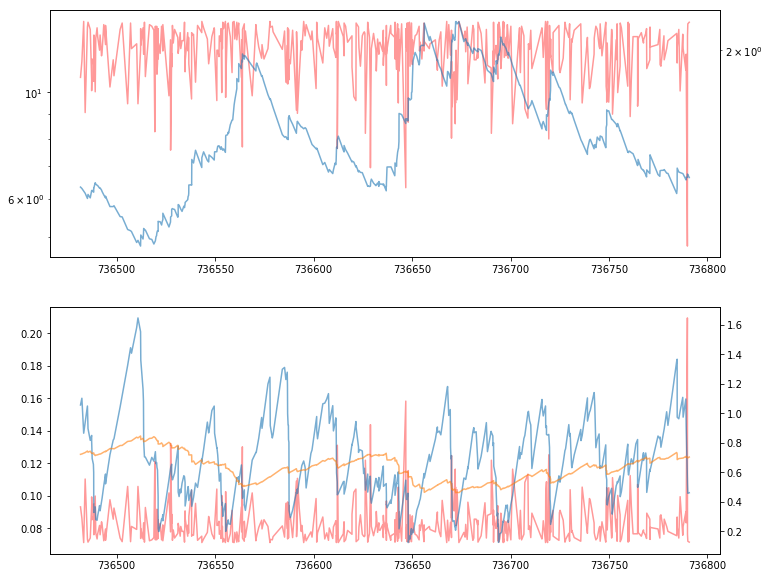

In [227]:
rates=numpy.array(rates)
#
ts = rates.T[0]
# rates_1   = 1.0/numpy.diff(ts)
# rates_10  = 1.0/numpy.array([(t2-t1)/10. for t1,t2 in zip(ts[0:-10], ts[10:])])
# rates_100 = 1.0/numpy.array([(t2-t1)/100. for t1,t2 in zip(ts[0:-100], ts[100:])])
#
intervals_0 = 1./rates.T[1]

intervals_1 = numpy.diff(ts)
rates_1 = 1.0/intervals_1
#
intervals_10 = numpy.array([(t2-t1)/10. for t1,t2 in zip(ts[0:-10], ts[10:])])
rates_10     = 1.0/intervals_10
#
intervals_100 = numpy.array([(t2-t1)/100. for t1,t2 in zip(ts[0:-100], ts[100:])])
rates_100     = 1.0/intervals_100
#
# let's also look at a simper sequence, like the sigma() metric, based on GR scaling.
m0 = 3.0
n=1
intervals_GR_1 = numpy.array([(t2-t1)*(10.**(m0-m-numpy.log10(n))) for t1,t2,m in zip(ts[0:-n], ts[n:], etas.catalog['mag'][n:])])
n=10
intervals_GR_10 = numpy.array([(t2-t1)*(10.**(m0-m-numpy.log10(n))) for t1,t2,m in zip(ts[0:-n], ts[n:], etas.catalog['mag'][n:])])
n=100
intervals_GR_100 = numpy.array([(t2-t1)*(10.**(m0-m-numpy.log10(n))) for t1,t2,m in zip(ts[0:-n], ts[n:], etas.catalog['mag'][n:])])


#
k_start = 500
#
print(rates[0:10])
plt.figure(figsize=(12,10))
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
#
ax1a = ax1
ax1a = ax1.twinx()
ax1.set_yscale('log')
ax1a.set_yscale('log')

#
ax1.plot(*zip(*rates[-k_start:]), ls='-', zorder=5, alpha=.4, color='r')
print(len(ts), len(rates_1))
#
# TODO: handle the sub-sequencing properly, so we don't over/under-run array lengths.
#
#ax1a.plot(ts[-k_start:], rates_1[-k_start+1:], alpha=.4)
#ax1a.plot(ts[-k_start:], rates_10[-k_start+10:], alpha=.6)
ax1a.plot(ts[-k_start:], rates_100[-k_start:], alpha=.6)
#
ax2a = ax2.twinx()
#ax.set_yscale('log')
#axa = ax
#
ax2.plot(ts[-k_start:], intervals_0[-k_start:], ls='-', zorder=5, alpha=.4, color='r')
print(len(ts), len(rates_1))
#
#ax2a.plot(ts[-k_start+1:], 1./rates_1[-k_start:], alpha=.4)

ax2a.plot(ts[-k_start:], intervals_10[-k_start:], alpha=.6)
ax2a.plot(ts[-k_start:], intervals_100[-k_start:], alpha=.6)

#
z0 = max(rates.T[1])
#ax1.set_ylim(-.1*z0, 1.5*z0)

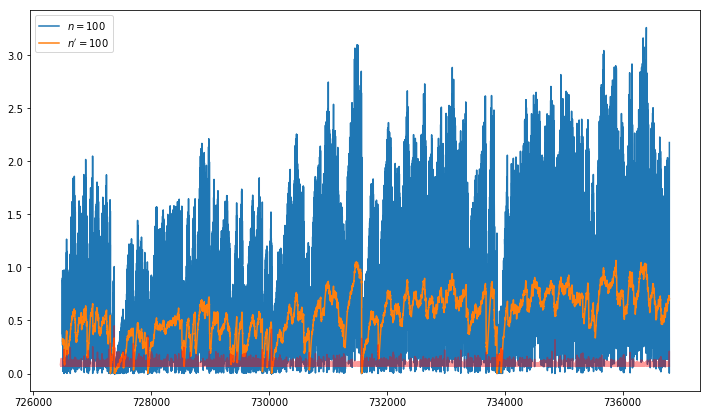

In [232]:
plt.figure(figsize=(12,7))
ax1 = plt.subplot('111')
#
Y = intervals_GR_1 
#ax1.plot(ts[-len(Y):], Y, '-', label='$n=1$')

Y = intervals_GR_10 
#ax1.plot(ts[-len(Y):], Y, '-', label='$n=10$')

Y = intervals_GR_100 
ax1.plot(ts[-len(Y):], Y, '-', label='$n=100$')
Y = intervals_100
ax1.plot(ts[-len(Y):], Y, '-', label='$n\'=100$')

ax1.plot(ts, intervals_0, ls='-', zorder=5, alpha=.4, color='r')

ax1.legend(loc=0)

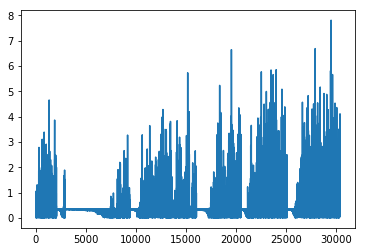

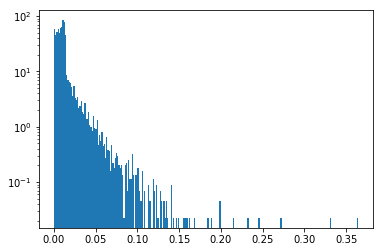

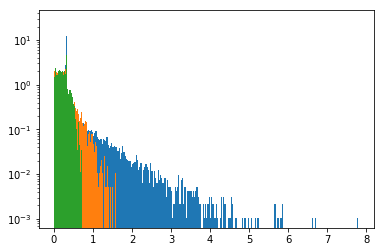

In [203]:
# what do the variance distributions look like?
# basically, but mean-differencing over 10 or 100 give a very similar
#  mean variance with quyalitatively simlar distributions. variance on the ETAS based model is much closer to
#  being zero-centered.
#
diff_rms = numpy.sqrt((rates.T[1]-numpy.mean(rates.T[1]))**2.)
diff_rms1 = numpy.sqrt((rates_1-numpy.mean(rates_1))**2.)

int_diff_rms  = numpy.sqrt((intervals_0 - numpy.mean(intervals_0))**2.)
int_diff_rms1 = numpy.sqrt((intervals_1 - numpy.mean(intervals_1))**2.)
int_diff_rms10 = numpy.sqrt((intervals_10 - numpy.mean(intervals_10))**2.)
int_diff_rms100 = numpy.sqrt((intervals_100 - numpy.mean(intervals_100))**2.)

plt.figure()
plt.plot(int_diff_rms1)

do_log=True
plt.figure()
h = plt.hist(int_diff_rms, 250,normed=True, log=do_log)

plt.figure()
h = plt.hist(int_diff_rms1, 250,normed=True, log=do_log)

#plt.figure()
h = plt.hist(int_diff_rms10, 250,normed=True, log=do_log)

#plt.figure()
h = plt.hist(int_diff_rms100, 250,normed=True, log=do_log)

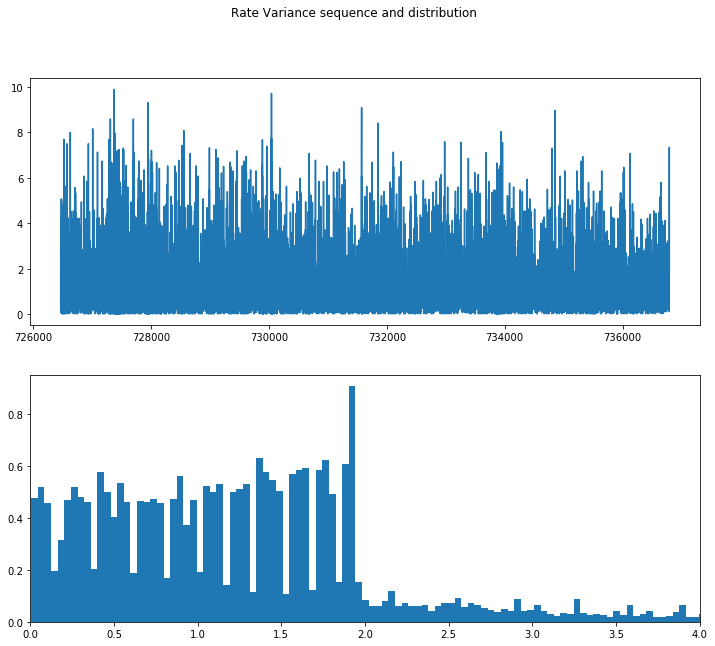

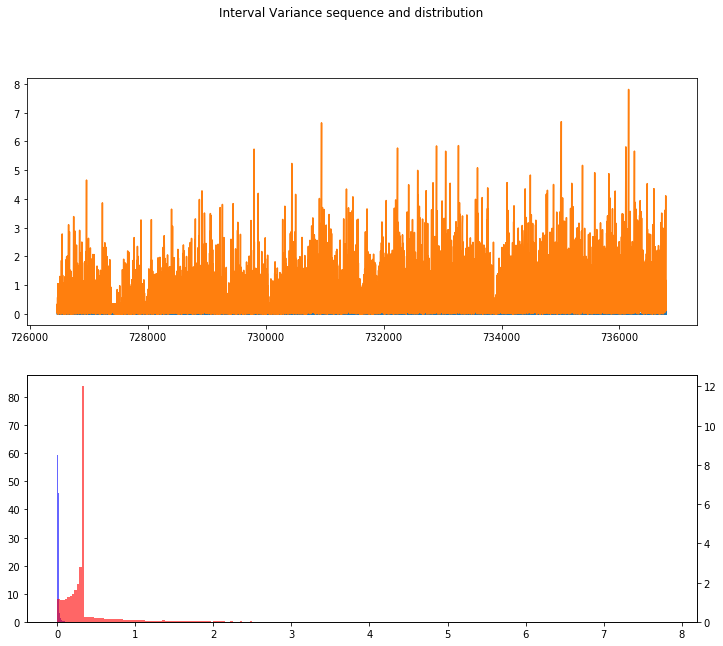

In [204]:
#
plt.figure(figsize=(12,10))
plt.suptitle('Rate Variance sequence and distribution')

ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
#
ax1.plot(rates.T[0], diff_rms, '-')
#ax1.plot(rates.T[0][1:], diff_rms1, '-')
#
hh = ax2.hist(diff_rms, 250, normed=True)
#
#hh1 = ax2.hist(diff_rms1, 250, normed=True)

ax2.set_xlim(0., 4)

#
plt.figure(figsize=(12,10))
plt.suptitle('Interval Variance sequence and distribution')
ax1 = plt.subplot('211')
ax2 = plt.subplot('212')
ax2a = ax2.twinx()
#
ax1.plot(rates.T[0], int_diff_rms, '-')
ax1.plot(rates.T[0][1:], int_diff_rms1, '-')
#
hh = ax2.hist(int_diff_rms, 250, normed=True, color='b', alpha=.6)
#
hh1 = ax2a.hist(int_diff_rms1, 250, normed=True, color='r', alpha=.6)

# TODO: do this dynamically by finding the point of x% variance.

#ax2.set_xlim(0., .05)

### Interval and rate distributions
- double-triple check the codes on this, but what appears to be interesting is that the ETAS sequence produces exactly the opposite rate profile. definitely much less variability, but it actually seemst to suggest some sort of most likely mean rate >>0, and then a <<that probabiility of significantly higher rates.
- ... but mostly it is interesting because the rate probability distribution is opposite from binning.
- TODO: check out the cumulative distributions.


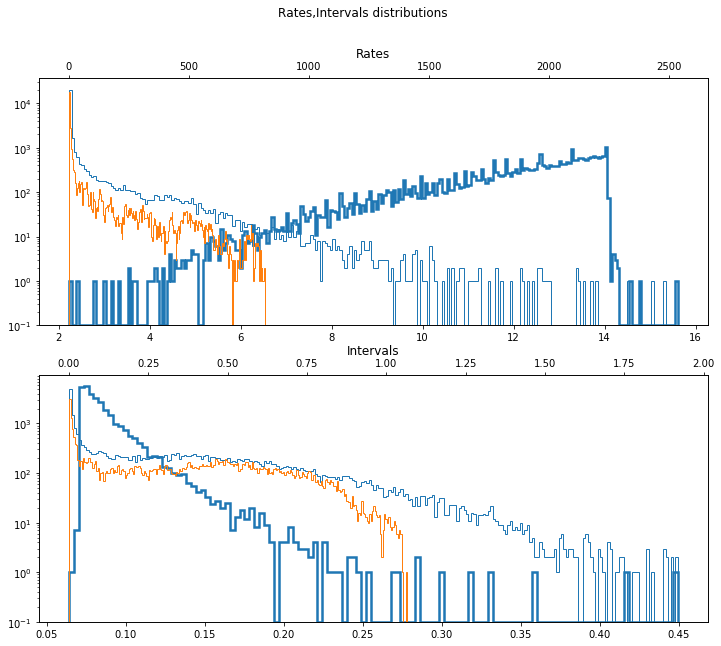

In [212]:
## What about just the distribution of the invervals or rates?
#
plt.figure(figsize=(12,10))
plt.suptitle('Rates,Intervals distributions')

ax1 = plt.subplot('211')
ax1a = ax1.twiny()
ax1.set_title('Rates\n')
ax2 = plt.subplot('212')
ax2a = ax2.twiny()
#ax2a = ax2
#ax1a = ax1
ax2.set_title('Intervals\n')
#
n=250
do_log=True
h = ax1.hist(rates.T[1], n, histtype='step', log=do_log, lw=2.5)
#h = ax1a.hist(rates_1,n, histtype='step', log=do_log)
h = ax1a.hist(rates_10,n, histtype='step', log=do_log)
h = ax1a.hist(rates_100,n, histtype='step', log=do_log)

h = ax2.hist(intervals_0, int(n/2), histtype='step', log=do_log, lw=2.5)
#h = ax2a.hist(intervals_1,n, histtype='step', log=do_log)
h = ax2a.hist(intervals_10,n, histtype='step', log=do_log)
h = ax2a.hist(intervals_100,n, histtype='step', log=do_log)

#plt.figure(figsize=(12,10))
#plt.suptitle('Intervals distributions')
#
#ax1 = plt.subplot('211')
#ax2 = plt.subplot('212')
#ax1.set_xlim(0., 200)

In [82]:
print(etas.catalog[0:5])
print(etas.catalog.dtype.descr)
print('days_to_secs: ', gep.days2secs)
print('len: ',len(etas.catalog))

[ (datetime.datetime(1990, 1, 1, 1, 3, 44, 490000), 34.546, -118.934, 2.95, 16.12, 726468.0442649305, 0.5188000389289612, 0.04568518726339412, 33.200321628147044, 0.15667510701081502, 0.002385645049932602, 64.89921104359364, 1.0, 1.1, 1.5, array([ 1.,  1.]), array([[ 1.,  0.],
       [ 0.,  1.]]), 3.0)
 (datetime.datetime(1990, 1, 1, 1, 4, 13, 760000), 34.543, -118.923, 2.77, 16.34, 726468.0446037037, 0.4216965034285822, 0.029303417083540128, 62.74380646072157, 0.12735030810166623, 0.001470976814004027, 103.0954306898618, 1.0, 1.1, 1.5, array([ 1.,  1.]), array([[ 1.,  0.],
       [ 0.,  1.]]), 1.0)
 (datetime.datetime(1990, 1, 1, 8, 8, 2, 500000), 35.983, -118.357, 2.61, 4.23, 726468.3389178241, 0.35075187395256796, 0.01974648024752856, 110.4803771395617, 0.10592537251772892, 0.0009570599894487624, 155.5629190841638, 1.0, 1.1, 1.5, array([  4.80916590e-06,   8.43666743e-06]), array([[-0.77640365,  0.63023597],
       [-0.63023597, -0.77640365]]), 16.0)
 (datetime.datetime(1990, 1, 1, 